In [1]:
import os
import json
import pandas as pd
from tqdm import tqdm
from numpy.linalg import norm
from dotenv import load_dotenv

from openai import OpenAI
from qdrant_client import QdrantClient, models
from transformers import AutoModel
from sentence_transformers import SentenceTransformer

/home/codespace/.local/share/virtualenvs/running-assistant-rag-j-iIWklV/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)

In [3]:
qd_client = QdrantClient("http://localhost:6333")
EMBEDDING_DIMENSIONALITY = 512
model_handle = "jinaai/jina-embeddings-v2-small-en"
collection_name = "running-faq"

In [4]:
with open('docs-with-ids.json', 'rt') as f_in:
    documents = json.load(f_in)

In [5]:
df_ground_truth = pd.read_csv('ground-truth-data.csv')

In [6]:
ground_truth = df_ground_truth.to_dict(orient='records')

In [7]:
def vector_search(question):
    # print('vector_search is used')
    
    query_points = qd_client.query_points(
        collection_name=collection_name,
        query=models.Document(
            text=question,
            model=model_handle 
        ),
        limit=5,
        with_payload=True
    )
    
    results = []
    
    for point in query_points.points:
        results.append(point.payload)
    
    return results

In [8]:
def build_prompt(query, search_results):
    prompt_template = """
You are a personal trainer specialized in running.

Answer the QUESTION at the end based on the full CONTEXT below, which contains multiple relevant FAQ entries.
Use **all available context entries** to form your answer. If multiple answers apply, summarize or combine them clearly.
Don't mention the Entry number like [Entry 5] in your answer.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context_entries = []
    
    for i, doc in enumerate(search_results, start=1):
        entry = (
            f"[Entry {i}]\n"
            f"Section: {doc['section']}\n"
            f"Question: {doc['question']}\n"
            f"Answer: {doc['text']}"
        )
        context_entries.append(entry)

    context = "\n\n".join(context_entries)
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [9]:
def llm(prompt, model_llm):
    # uncomment to see full prompt
    # print(prompt)
    response = client.chat.completions.create(
        model=model_llm,
        messages=[{"role": "user", "content": prompt}],
        temperature=1.5,
        top_p=0.9,
        frequency_penalty=0.0,
        presence_penalty=0.0,
        max_tokens=1000,
    )
    
    return response.choices[0].message.content

In [10]:
def rag(query, model_llm='gpt-4o'):
    search_results = vector_search(query)
    prompt = build_prompt(query, search_results)
    answer = llm(prompt, model_llm)
    return answer

# Retrieval Evaluation

In [12]:
relevance_total = []

for q in tqdm(ground_truth):
    doc_id = q['document']
    results = vector_search(question=q['question'])
    relevance = [d['id'] == doc_id for d in results]
    relevance_total.append(relevance)

100%|██████████| 486/486 [00:05<00:00, 84.78it/s] 


In [13]:
def hit_rate(relevance_total):
    cnt = 0

    for line in relevance_total:
        if True in line:
            cnt = cnt + 1

    return cnt / len(relevance_total)

In [14]:
def mrr(relevance_total):
    total_score = 0.0

    for line in relevance_total:
        for rank in range(len(line)):
            if line[rank] == True:
                total_score = total_score + 1 / (rank + 1)

    return total_score / len(relevance_total)

In [15]:
hit_rate(relevance_total), mrr(relevance_total)

(0.9526748971193416, 0.8632030178326474)

# Offline evaluation

In [11]:
cos_sim = lambda a,b: (a @ b.T) / (norm(a)*norm(b))

In [12]:
model = AutoModel.from_pretrained('jinaai/jina-embeddings-v2-small-en', trust_remote_code=True) # trust_remote_code is needed to use the encode method

In [13]:
embeddings = model.encode(['How is the weather today?', 'What is the current weather like today?'])

In [16]:
print(cos_sim(embeddings[0], embeddings[1]))

0.9399813


In [14]:
doc_idx = {d['id']: d for d in documents}

In [18]:
doc_idx

{'1ce0afbb': {'text': 'Interval training is a training method in which phases of intense effort alternate with recovery phases. This alternation between high and low intensity effectively improves endurance and speed, as the body is challenged both anaerobically and aerobically.',
  'section': 'Training',
  'question': 'What is interval training?',
  'id': '1ce0afbb'},
 'c4c003a1': {'text': "Long, slow runs are a central component of endurance training. They help improve basic endurance, strengthen the cardiovascular system, and increase the body's ability to burn fat. These runs also help prepare muscles and tendons for longer periods of exertion.",
  'section': 'Training',
  'question': 'What are long, slow runs good for?',
  'id': 'c4c003a1'},
 '0c19360d': {'text': 'Recovery is an essential part of the training process. During recovery phases, the body can recover from training stimuli, repair muscle tissue, and adapt to the exertion. Without sufficient recovery, the risk of injury,

In [19]:
ground_truth[5]

{'question': 'How do long, slow runs benefit endurance training?',
 'document': 'c4c003a1'}

In [20]:
rag(ground_truth[5]['question'])

Fetching 5 files: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


"Long, slow runs are essential for endurance training as they play a significant role in enhancing basic endurance. They strengthen the cardiovascular system and increase the body's ability to burn fat. Additionally, these runs prepare muscles and tendons to handle longer durations of exertion, making them crucial for improving overall endurance."

In [21]:
doc_idx['c4c003a1']['text']

"Long, slow runs are a central component of endurance training. They help improve basic endurance, strengthen the cardiovascular system, and increase the body's ability to burn fat. These runs also help prepare muscles and tendons for longer periods of exertion."

In [22]:
text_rag = 'Long, slow runs are highly beneficial for endurance training as they play a crucial role in enhancing basic endurance and strengthening the cardiovascular system. These runs help the body become more efficient at burning fat, which is an essential energy source during prolonged exertion. Additionally, they condition muscles and tendons to handle longer durations of physical activity, thereby preparing the body for sustained efforts in endurance events.'
text_orig = 'Long, slow runs are a central component of endurance training. They help improve basic endurance, strengthen the cardiovascular system, and increase the bodys ability to burn fat. These runs also help prepare muscles and tendons for longer periods of exertion.'

In [23]:
embeddings = model.encode([text_rag, text_orig])

In [24]:
print(cos_sim(embeddings[0], embeddings[1]))

0.97841454


In [25]:
answers = {}

In [26]:
ground_truth[0]

{'question': 'How does alternating between intense and recovery phases benefit a runner?',
 'document': '1ce0afbb'}

In [39]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue

    answer_llm = rag(rec['question'])
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question']
    }

100%|██████████| 486/486 [13:05<00:00,  1.62s/it]


In [17]:
answers_4o_mini = {}

for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers_4o_mini:
        continue

    answer_llm = rag(rec['question'], model_llm='gpt-4o-mini')
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers_4o_mini[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question']
    }

100%|██████████| 486/486 [21:34<00:00,  2.66s/it]


In [40]:
answers

{0: {'answer_llm': 'Alternating between intense and recovery phases benefits a runner by improving both endurance and speed. The method of interval training, where high-intensity efforts are alternated with recovery periods, challenges the body both anaerobically and aerobically. This alternation allows the body to adapt and become stronger during the intense phases, while the recovery phases are essential for repairing muscle tissue and reducing the risk of injury and overuse. Therefore, integrating these alternating phases into a training regimen supports optimal performance and decreases the chances of decreased performance due to insufficient recovery.',
  'answer_orig': 'Interval training is a training method in which phases of intense effort alternate with recovery phases. This alternation between high and low intensity effectively improves endurance and speed, as the body is challenged both anaerobically and aerobically.',
  'document': '1ce0afbb',
  'question': 'How does altern

In [18]:
answers_4o_mini

{0: {'answer_llm': 'Alternating between intense and recovery phases benefits a runner in several key ways. This approach, known as interval training, allows the body to experience both anaerobic and aerobic challenges, which effectively enhances endurance and speed. During the intense phases, the body is pushed to adapt and improve, while the recovery phases are crucial for allowing the body to repair muscle tissue, recover from the exertion, and prevent injury or overuse. Sufficient recovery is essential for overall performance improvement, as it helps maintain the balance needed to optimize training benefits and minimize the risk of injuries. Ultimately, this combination of effort and recovery leads to better overall performance for runners.',
  'answer_orig': 'Interval training is a training method in which phases of intense effort alternate with recovery phases. This alternation between high and low intensity effectively improves endurance and speed, as the body is challenged both 

In [41]:
results_gpt4o = [None] * len(ground_truth)

for i, val in answers.items():
    results_gpt4o[i] = val.copy()
    results_gpt4o[i].update(ground_truth[i])

In [19]:
results_gpt4o_mini = [None] * len(ground_truth)

for i, val in answers_4o_mini.items():
    results_gpt4o_mini[i] = val.copy()
    results_gpt4o_mini[i].update(ground_truth[i])

In [42]:
df_gpt4o = pd.DataFrame(results_gpt4o)

In [20]:
df_gpt4o_mini = pd.DataFrame(results_gpt4o_mini)

In [43]:
df_gpt4o.head()

,answer_llm,answer_orig,document,question
0,Alternating between intense and recovery phase...,Interval training is a training method in whic...,1ce0afbb,How does alternating between intense and recov...
1,"Yes, combining high and low intensity in worko...",Interval training is a training method in whic...,1ce0afbb,Can combining high and low intensity in workou...
2,Challenging your body with varying intensity l...,Interval training is a training method in whic...,1ce0afbb,What are the benefits of challenging your body...
3,Incorporating phases of intense effort and res...,Interval training is a training method in whic...,1ce0afbb,Why might a runner consider incorporating phas...
4,"Alternating effort levels in training, as seen...",Interval training is a training method in whic...,1ce0afbb,How can alternating effort levels in training ...


In [21]:
df_gpt4o_mini.head()

,answer_llm,answer_orig,document,question
0,Alternating between intense and recovery phase...,Interval training is a training method in whic...,1ce0afbb,How does alternating between intense and recov...
1,"Yes, combining high and low intensity in worko...",Interval training is a training method in whic...,1ce0afbb,Can combining high and low intensity in workou...
2,Challenging your body with varying intensity l...,Interval training is a training method in whic...,1ce0afbb,What are the benefits of challenging your body...
3,A runner might consider incorporating phases o...,Interval training is a training method in whic...,1ce0afbb,Why might a runner consider incorporating phas...
4,"Alternating effort levels in training, such as...",Interval training is a training method in whic...,1ce0afbb,How can alternating effort levels in training ...


In [44]:
!mkdir data

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [45]:
df_gpt4o.to_csv('data/results-gpt4o.csv', index=False)

In [22]:
df_gpt4o_mini.to_csv('data/results-gpt4o_mini.csv', index=False)

In [23]:
df_gpt4o = pd.read_csv('data/results-gpt4o.csv')

In [24]:
df_gpt4o.head()

,answer_llm,answer_orig,document,question,cosine
0,Alternating between intense and recovery phase...,Interval training is a training method in whic...,1ce0afbb,How does alternating between intense and recov...,0.954126
1,"Yes, combining high and low intensity in worko...",Interval training is a training method in whic...,1ce0afbb,Can combining high and low intensity in workou...,0.930447
2,Challenging your body with varying intensity l...,Interval training is a training method in whic...,1ce0afbb,What are the benefits of challenging your body...,0.860508
3,Incorporating phases of intense effort and res...,Interval training is a training method in whic...,1ce0afbb,Why might a runner consider incorporating phas...,0.944543
4,"Alternating effort levels in training, as seen...",Interval training is a training method in whic...,1ce0afbb,How can alternating effort levels in training ...,0.938607


In [29]:
results_gpt4o = df_gpt4o.to_dict(orient='records')

In [25]:
results_gpt4o_mini = df_gpt4o.to_dict(orient='records')

In [30]:
record = results_gpt4o[0]

In [35]:
record_gpt_4o_mini = results_gpt4o_mini[0]

In [31]:
embeddings = model.encode([text_rag, text_orig])

print(cos_sim(embeddings[0], embeddings[1]))

0.97841454


In [ ]:
v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

print(cos_sim(v_llm, v_orig))

In [26]:
def compute_similarity(record):

    embeddings = model.encode([record['answer_llm'], record['answer_orig']])
    
    return cos_sim(embeddings[0], embeddings[1])

In [30]:
results_gpt4o_mini[0]

{'answer_llm': 'Alternating between intense and recovery phases benefits a runner by improving both endurance and speed. The method of interval training, where high-intensity efforts are alternated with recovery periods, challenges the body both anaerobically and aerobically. This alternation allows the body to adapt and become stronger during the intense phases, while the recovery phases are essential for repairing muscle tissue and reducing the risk of injury and overuse. Therefore, integrating these alternating phases into a training regimen supports optimal performance and decreases the chances of decreased performance due to insufficient recovery.',
 'answer_orig': 'Interval training is a training method in which phases of intense effort alternate with recovery phases. This alternation between high and low intensity effectively improves endurance and speed, as the body is challenged both anaerobically and aerobically.',
 'document': '1ce0afbb',
 'question': 'How does alternating b

In [31]:
compute_similarity(results_gpt4o_mini[0])

np.float32(0.954126)

In [34]:
similarity = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity.append(sim)

100%|██████████| 486/486 [00:20<00:00, 23.78it/s]


In [32]:
similarity_gpt_4o_mini = []

for record in tqdm(results_gpt4o_mini):
    sim = compute_similarity(record)
    similarity_gpt_4o_mini.append(sim)

100%|██████████| 486/486 [00:20<00:00, 23.88it/s]


In [35]:
df_gpt4o['cosine'] = similarity
df_gpt4o['cosine'].describe()

count    486.000000
mean       0.932216
std        0.036102
min        0.632272
25%        0.920174
50%        0.939577
75%        0.953818
max        1.000000
Name: cosine, dtype: float64

In [34]:
df_gpt4o_mini['cosine'] = similarity_gpt_4o_mini
df_gpt4o_mini['cosine'].describe()

count    486.000000
mean       0.932216
std        0.036102
min        0.632272
25%        0.920174
50%        0.939577
75%        0.953818
max        1.000000
Name: cosine, dtype: float64

In [36]:
df_gpt4o.to_csv('data/results-gpt4o.csv', index=False)

In [36]:
df_gpt4o_mini.to_csv('data/results-gpt4o_mini.csv', index=False)

/tmp/ipykernel_29699/3871014666.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'], label='4o')
/tmp/ipykernel_29699/3871014666.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o_mini['cosine'], label='4o-mini')


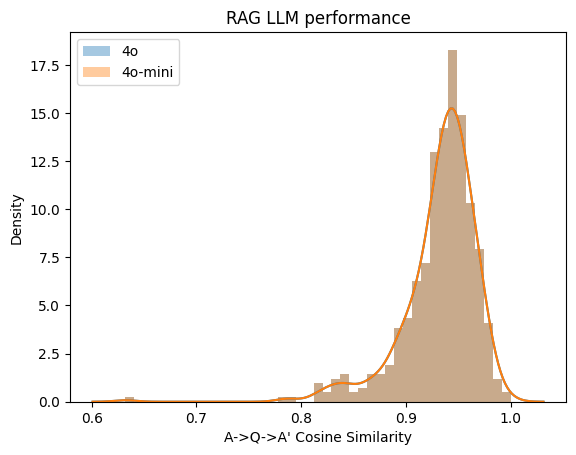

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(df_gpt4o['cosine'], label='4o')
sns.distplot(df_gpt4o_mini['cosine'], label='4o-mini')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

In [44]:
df_gpt4o[df_gpt4o['cosine'] <= 0.8]

,answer_llm,answer_orig,document,question,cosine
131,When selecting running shoes to avoid injuries...,Overuse injuries can be caused by rapid increa...,607985ef,What should I consider when selecting running ...,0.788789
132,Paying attention to your running technique is ...,Overuse injuries can be caused by rapid increa...,607985ef,Why is it important to pay attention to my run...,0.785134
315,Could you please clarify your question so that...,Running can increase bone density and help pre...,9676492f,questions,0.632272


In [41]:
df_gpt4o_mini[df_gpt4o['cosine'] <= 0.8]

,answer_llm,answer_orig,document,question,cosine
131,When selecting running shoes to avoid injuries...,Overuse injuries can be caused by rapid increa...,607985ef,What should I consider when selecting running ...,0.788789
132,Paying attention to your running technique is ...,Overuse injuries can be caused by rapid increa...,607985ef,Why is it important to pay attention to my run...,0.785134
315,Here are some common questions related to runn...,Running can increase bone density and help pre...,9676492f,questions,0.632272


# LLM-as-a-judge

In [42]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [46]:
results_gpt4o_mini[0]

{'answer_llm': 'Alternating between intense and recovery phases benefits a runner by improving both endurance and speed. The method of interval training, where high-intensity efforts are alternated with recovery periods, challenges the body both anaerobically and aerobically. This alternation allows the body to adapt and become stronger during the intense phases, while the recovery phases are essential for repairing muscle tissue and reducing the risk of injury and overuse. Therefore, integrating these alternating phases into a training regimen supports optimal performance and decreases the chances of decreased performance due to insufficient recovery.',
 'answer_orig': 'Interval training is a training method in which phases of intense effort alternate with recovery phases. This alternation between high and low intensity effectively improves endurance and speed, as the body is challenged both anaerobically and aerobically.',
 'document': '1ce0afbb',
 'question': 'How does alternating b

In [47]:
record = results_gpt4o_mini[0]
record

{'answer_llm': 'Alternating between intense and recovery phases benefits a runner by improving both endurance and speed. The method of interval training, where high-intensity efforts are alternated with recovery periods, challenges the body both anaerobically and aerobically. This alternation allows the body to adapt and become stronger during the intense phases, while the recovery phases are essential for repairing muscle tissue and reducing the risk of injury and overuse. Therefore, integrating these alternating phases into a training regimen supports optimal performance and decreases the chances of decreased performance due to insufficient recovery.',
 'answer_orig': 'Interval training is a training method in which phases of intense effort alternate with recovery phases. This alternation between high and low intensity effectively improves endurance and speed, as the body is challenged both anaerobically and aerobically.',
 'document': '1ce0afbb',
 'question': 'How does alternating b

In [48]:
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: Interval training is a training method in which phases of intense effort alternate with recovery phases. This alternation between high and low intensity effectively improves endurance and speed, as the body is challenged both anaerobically and aerobically.
Generated Question: How does alternating between intense and recovery phases benefit a runner?
Generated Answer: Alternating between intense and recovery phases benefits a runner by improving both endurance and speed. The method of interval training, where high-intensity efforts are alternated with recovery periods, challenges the body both anaer

In [50]:
answer = llm(prompt, model_llm='gpt-4o-mini')

In [52]:
print(answer)

{
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer directly addresses the benefits of alternating intense and recovery phases for runners, which is the main focus of the original answer. It includes key points about improving endurance and speed, the anaerobic and aerobic challenges posed by interval training, and the importance of recovery. The details provided in the generated answer align closely with the content of the original answer, making it highly relevant."
}


In [55]:
evaluations = []

for record in tqdm(results_gpt4o_mini):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model_llm='gpt-4o-mini')
    evaluations.append(evaluation)

100%|██████████| 486/486 [12:41<00:00,  1.57s/it]


In [56]:
json_evaluations = []

for i, str_eval in enumerate(evaluations):
    json_eval = json.loads(str_eval)
    json_evaluations.append(json_eval)

In [57]:
df_evaluations = pd.DataFrame(json_evaluations)

In [58]:
df_evaluations.Relevance.value_counts()

Relevance
RELEVANT           459
PARTLY_RELEVANT     26
NON_RELEVANT         1
Name: count, dtype: int64

In [59]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT']

,Relevance,Explanation
315,NON_RELEVANT,The generated answer does not address the cont...


In [60]:
prompt2 = prompt2_template.format(**record)
print(prompt2)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: Does running enhance my immune function?
Generated Answer: Yes, running can enhance your immune function by strengthening the immune system and reducing your susceptibility to illness.

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}


In [62]:
evaluation2 = llm(prompt2, model_llm='gpt-4o-mini')
print(evaluation2)

{
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer directly addresses the question about running and its effect on immune function, providing a clear and affirmative response along with reasoning on how it enhances the immune system."
}


In [64]:
evaluations_2 = []

for record in tqdm(results_gpt4o_mini):
    prompt = prompt2_template.format(**record)
    evaluation = llm(prompt, model_llm='gpt-4o-mini')
    evaluations_2.append(evaluation)

100%|██████████| 486/486 [12:29<00:00,  1.54s/it]


In [65]:
json_evaluations_2 = []

for i, str_eval in enumerate(evaluations_2):
    json_eval = json.loads(str_eval)
    json_evaluations_2.append(json_eval)

In [66]:
df_evaluations_2 = pd.DataFrame(json_evaluations_2)

In [67]:
df_evaluations_2[df_evaluations_2.Relevance == 'NON_RELEVANT']

,Relevance,Explanation
315,NON_RELEVANT,The generated answer does not address the ques...


In [68]:
df_evaluations.to_csv('data/evaluations-aqa.csv', index=False)
df_evaluations_2.to_csv('data/evaluations-qa.csv', index=False)